In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

from sklearn.preprocessing import LabelEncoder

# For tuning the model

from sklearn.model_selection import GridSearchCV

# To check the model performance

from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
#loading the dataset to a dataframe
df= pd.read_csv('healthcare_data.csv')
#data exploration 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   patientid                          500000 non-null  int64  
 6   Age                                500000 non-null  object 
 7   gender                             500000 non-null  object 
 8   Type of Admission                  500000 non-null  object 
 9   Severity of Illness                500000 non-null  object 
 10  health_conditions                  500000 non-null  object 
 11  Visitors with Patient              5000

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [ ]:
#creating a copy of the data so as not to make changes to the original
same_data= df.copy()

In [ ]:
#checking for duplicate values
df.duplicated().sum()

0

# Data Preparation for Model Building

In [3]:
 #Creating dummy variables for the categorical columns, drop_first = True is used to avoid redundant variables
df = pd.get_dummies(
    df,
    columns = df.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)

In [4]:
df.head()

,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit,Stay (in days),Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,...,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other,Insurance_Yes
0,4,0,33070,4,2966.408696,8,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1,4,2,34808,2,3554.835677,9,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
2,2,8,44577,2,5624.733654,7,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
3,4,7,3695,4,4814.149231,8,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
4,2,10,108956,2,5169.269637,34,1,0,0,0,...,1,0,0,1,1,0,0,0,0,0


In [5]:
#dropping patientid from the dataframe since it is a n identifier
df = df.drop(['patientid'],axis = 1)

In [6]:
#seperating the feature variables and target variables
x = df.drop('Stay (in days)',axis = 1)

y = df['Stay (in days)'] 

In [7]:
#splitting the training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

#checking the shape of the train and test set
print('Train Shape:',x_train.shape)
print('Test Shape:',x_test.shape)

Train Shape: (400000, 42)
Test Shape: (100000, 42)


# Model Building

Defining Functions for model performance

In [8]:
# Function to compute the adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    
    r2 = r2_score(targets, predictions)
    
    n = predictors.shape[0]
    
    k = predictors.shape[1]
    
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Function to compute MAPE
def mape_score(targets, predictions):
    
    return np.mean(np.abs(targets - predictions) / targets) * 100

# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))
  
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):

    # Predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)                      # To compute R-squared
    
    adjr2 = adj_r2_score(predictors, target, pred)   # To compute adjusted R-squared
    
    rmse = np.sqrt(mean_squared_error(target, pred)) # To compute RMSE
    
    mae = mean_absolute_error(target, pred)          # To compute MAE
    
    mape = mape_score(target, pred)                  # To compute MAPE

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "RMSE":  rmse,
            "MAE":  mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        
        index = [0],
    )

    return df_perf



def model_pref(olsmodel, x_train, x_test, y_train,y_test):

    # Prediction on the training data
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on the test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    ) 

Using the OLS model to estimate coefficients of linear regression equations to describe the relationship between the variables

In [9]:
#fitting the OLS model 
import statsmodels.api as sm

# Statsmodel api does not add a constant by default, we need to add it explicitly
x_train1 = sm.add_constant(x_train)

# Add constant to the test data
x_test1 = sm.add_constant(x_test)

# Create the model
olsmodel1 = sm.OLS(y_train, x_train1).fit()

# Get the model summary
olsmodel1.summary()


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Stay (in days)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 5.643e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:11:12   Log-Likelihood:            -1.0246e+06
No. Observations:              400000   AIC:                         2.049e+06
Df Residuals:                  399961   BIC:                         2.050e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    19.8918      0.055    359.659      0.000      19.783      20.000
Available Extra Rooms in Hospital         0.0786      0.002     42.311      0.000       0.075       0.082
staff_available                          -0.0009      0.002     -0.588      0.557      -0.004       0.002
Visitors with Patient                     0.0002      0.002      0.099      0.921      -0.004       0.005
Admission_Deposit                     -3.839e-05   4.78e-06     -8.029      0.000   -4.78e-05    -2.9e-05
Department_anesthesia                     6.0823      0.029    210.110      0.000       6.026       6.139
Department_gynecology                     0.4635      0.019     24.149      0.000       0.426       0.501
Department_radiotherapy                  -4.6217      0.037   -126.135      0.000      -4.693      -4.550
Department_surgery                        9.6867      0.044    218.475      0.000       9.600       9.774
Ward_Facility_Code_B                      0.2571      0.011     23.468      0.000       0.236       0.279
Ward_Facility_Code_C                      0.4349      0.035     12.604      0.000       0.367       0.503
Ward_Facility_Code_D                      0.2033      0.011     19.313      0.000       0.183       0.224
Ward_Facility_Code_E                      0.3087      0.021     14.409      0.000       0.267       0.351
Ward_Facility_Code_F                      0.0031      0.011      0.282      0.778      -0.018       0.025
doctor_name_Dr John                       7.2631      0.031    232.919      0.000       7.202       7.324
doctor_name_Dr Mark                       1.1949      0.033     36.394      0.000       1.131       1.259
doctor_name_Dr Nathan                    -0.2164      0.017    -12.662      0.000      -0.250      -0.183
doctor_name_Dr Olivia                    -0.3620      0.016    -22.985      0.000      -0.393      -0.331
doctor_name_Dr Sam                        1.2836      0.038     33.875      0.000       1.209       1.358
doctor_name_Dr Sarah                      0.8252      0.020     41.740      0.000       0.786       0.864
doctor_name_Dr Simon                      6.1602      0.069     89.051      0.000       6.025       6.296
doctor_name_Dr Sophia                     0.2167      0.020     10.605      0.000       0.177       0.257
Age_11-20                               -12.7378      0.065   -194.584      0.000     -12.866     -12.609
Age_21-30                               -10.4830      0.062   -168.463      0.000     -10.605     -10.361
Age_31-40                               -13.4354      0.062   -216.955      0.000     -13.557     -13.314
Age_41-50                               -13.5113      0.062   -216.833      0.000     -13.633     -13.389
Age_51-60

In [ ]:
lin_reg_test = model_performance_regression(olsmodel1, x_test1, y_test)
lin_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144036,2.155759,0.84303,0.842962,19.676874


In [ ]:
model_pref(olsmodel1, x_train1, x_test1, y_train,y_test)

    Data      RMSE       MAE       MAPE
0  Train  3.135092  2.146240  19.591781
1   Test  3.144036  2.155759  19.676874


The RMSE of the train and test set are close meaning the model is not overfitting.<br>
The R-Squared is 0,84 meaning that not all variable sare significant in the model prediction.

# Dropping Insignificant Models

Insignificant variables have coefficients less than 0.05(fro the table above) therefore we will drop them.

In [10]:
# Dropping the specified features
x_train2 = x_train1.drop(columns = {'staff_available', 'Visitors with Patient', 'Ward_Facility_Code_F', 'Age_81-90', 'gender_Other', 'health_conditions_High Blood Pressure', 'health_conditions_None', 'health_conditions_Other', 'Insurance_Yes'})

x_test2 = x_test1.drop(columns = {'staff_available', 'Visitors with Patient', 'Ward_Facility_Code_F', 'Age_81-90', 'gender_Other', 'health_conditions_High Blood Pressure', 'health_conditions_None', 'health_conditions_Other', 'Insurance_Yes'})



Applying Cross Validation on Linear Regression Models

In [ ]:
from sklearn.model_selection import cross_val_score

# Build the regression model using sklearn linear regression
linearregression = LinearRegression()                                    

# cv = 10 indicates that the data is divided into 10 folds
cv_Score11 = cross_val_score(linearregression, x_train, y_train, cv = 10)

cv_Score12 = cross_val_score(linearregression, x_train, y_train, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  

print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))

print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1 * cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.843 (+/- 0.004)
Mean Squared Error: 9.832 (+/- 0.296)


The results are similar the solution to increase the R-Squared and decrease the Mean Squared Error is to use better features and a better model. 

# Random Forest Regressor

In [ ]:
# Random Forest Regressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 1)

# Fitting the model
regressor.fit(x_train2, y_train)

# Model Performance on the test data
regressor_perf_test = model_performance_regression(regressor, x_test2, y_test)

regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.456052,0.96941,0.966334,0.966322,8.188093


In [ ]:
# measuring performance of the model on the train and test sets
model_pref(regressor, x_train2, x_test2, y_train,y_test)

    Data      RMSE       MAE      MAPE
0  Train  0.543299  0.358882  3.033944
1   Test  1.456052  0.969410  8.188093


In [ ]:
#fitting the gradient boost regressor 
from sklearn.ensemble import GradientBoostingRegressor

GBreg = GradientBoostingRegressor(n_estimators = 100, random_state = 1, learning_rate=0.1, max_depth=3)

GBreg.fit(x_train2, y_train)

GBreg_perf_test = model_performance_regression(GBreg, x_test2, y_test)

GBreg_perf_test


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.793715,1.212468,0.948908,0.948891,10.232771


In [ ]:
#fitting XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
#fitting the model
xgb_model.fit(x_train2, y_train)
#measuring performance of the model
xgb_perf_test = model_performance_regression(xgb_model, x_test2, y_test)

xgb_perf_test


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.792402,1.21142,0.948983,0.948966,10.221274


In [ ]:
# measuring performance of the model on the train and test sets
model_pref(xgb_model, x_train2, x_test2, y_train,y_test)

    Data      RMSE       MAE       MAPE
0  Train  1.785553  1.207863  10.201695
1   Test  1.792402  1.211420  10.221274


In [ ]:
#fitting lightGBM
import lightgbm as lgb

# Define the dataset format for LightGBM
train_data = lgb.Dataset(x_train2, label=y_train)

# Set the hyperparameters for the model
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 1
}
#training the model
lgb_model = lgb.train(params, train_data, num_boost_round=100)


#measuring performance of the model
lgb_perf_test = model_performance_regression(lgb_model, x_test2, y_test)

lgb_perf_test



,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.605931,1.109202,0.959046,0.959032,9.517915


In [ ]:
# measuring performance of the model on the train and test sets
model_pref(lgb_model, x_train2, x_test2, y_train,y_test)

    Data      RMSE       MAE      MAPE
0  Train  1.592823  1.104325  9.496100
1   Test  1.605931  1.109202  9.517915


RandomForestRegressor performed best with the lowest RMSE(1.456) and the highest R-Squared(0.96).<br> Furthermore, the RMSE of the train and test set are not far apart showing that the model is not overfitting 

In [ ]:
#hyperparameter tuning using grid search
rf_tuned = RandomForestRegressor(random_state = 1)

# Define the hyperparameters to be tuned
param_grid = {
    "n_estimators": [110, 120],
    "max_depth": [5, 7],
    "max_features": [0.8, 1]
}


# Type of scoring used to compare parameter combinations
scorer = make_scorer(r2_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, param_grid, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train2, y_train)

# Set the rf_tuned_regressor to the best combination of parameters
rf_tuned_regressor = grid_obj.best_estimator_

rf_tuned_regressor.fit(x_train2, y_train)


RandomForestRegressor(max_depth=7, max_features=0.8, n_estimators=120,
                      random_state=1)

In [ ]:
rf_tuned_regressor_perf_test = model_performance_regression(rf_tuned_regressor, x_test2, y_test)

rf_tuned_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.727273,1.158884,0.952623,0.952607,9.667818


The tuned random forest regressor performs even worse

In [ ]:
#Fitting the best performing model
final_model = RandomForestRegressor(n_estimators = 100, random_state = 1)
final_model.fit(x_train2, y_train)

final_model_perf_train = model_performance_regression(final_model, x_train2, y_train)

final_model_perf_train

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.543299,0.358882,0.995279,0.995279,3.033944


In [ ]:
#final test on the test data
final_model_test_perf = model_performance_regression(final_model, x_test2, y_test)

print("Final Test Performance:")

final_model_test_perf

Final Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.456052,0.96941,0.966334,0.966322,8.188093


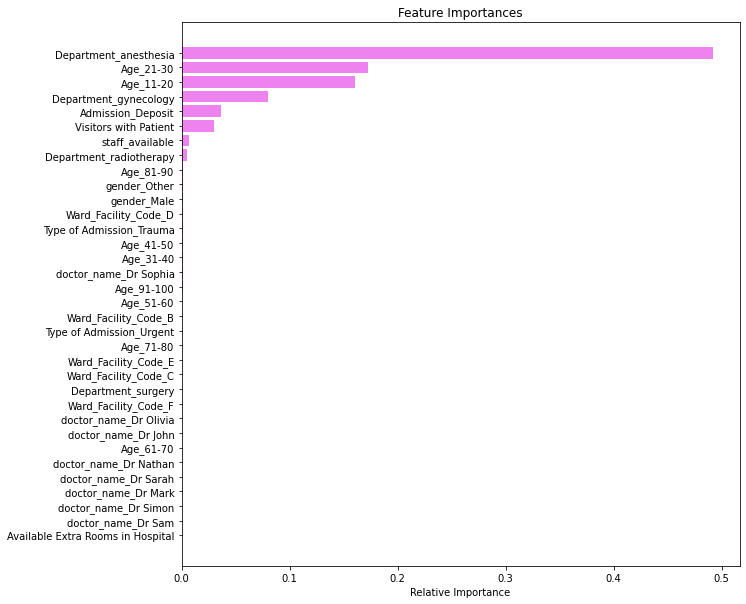

In [ ]:
import matplotlib.pyplot as plt

# Plotting the feature importance
importances = final_model.feature_importances_
features = x.columns
indices = np.argsort(importances)

plt.figure(figsize = (10, 10))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

# Neural Network

In [11]:
print(x_train2.shape)
print(y_train.shape)

(400000, 34)
(400000,)


In [12]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

#define the model
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train2.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4480      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 169,345
Trainable params: 169,345
Non-trainable params: 0
_________________________________________________________________


In [30]:
checkpoint_name = 'best_model.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [31]:
NN_model.fit(x_train2, y_train, epochs=30, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/30
 9997/10000 [============================>.] - ETA: 0s - loss: 1.5331 - mean_absolute_error: 1.5331
Epoch 1: val_loss improved from inf to 4.67282, saving model to best_model.hdf5
10000/10000 [==============================] - 67s 7ms/step - loss: 1.5344 - mean_absolute_error: 1.5344 - val_loss: 4.6728 - val_mean_absolute_error: 4.6728
Epoch 2/30
 9993/10000 [============================>.] - ETA: 0s - loss: 1.5251 - mean_absolute_error: 1.5251
Epoch 2: val_loss improved from 4.67282 to 3.67296, saving model to best_model.hdf5
10000/10000 [==============================] - 66s 7ms/step - loss: 1.5265 - mean_absolute_error: 1.5265 - val_loss: 3.6730 - val_mean_absolute_error: 3.6730
Epoch 3/30
 9996/10000 [============================>.] - ETA: 0s - loss: 2.4753 - mean_absolute_error: 2.4753
Epoch 3: val_loss improved from 3.67296 to 2.17102, saving model to best_model.hdf5
10000/10000 [==============================] - 70s 7ms/step - loss: 2.4751 - mean_absolute_error: 2.475

In [34]:
from keras.models import load_model
# Load the saved model
saved_model = load_model('best_model.hdf5')
# Make predictions on the testing data
y_pred = saved_model.predict(x_test2)

# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE:", rmse)
print("R-squared:", r2)

3125/3125 [==============================] - 8s 3ms/step
RMSE: 1.9097172349284284
R-squared: 0.9420864847583923


The RandomForestRegressor still has the best performance. with the lowest RMSWE and highest Rsquared